In [ ]:
# Importing important libraries
import pyspark
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler

In [ ]:
from pyspark import SparkContext
from pyspark.sql import SparkSession

In [ ]:
# Creating Spark Session and Spark Variable

sc = SparkContext()
spark = SparkSession.builder.master('local[1]').appName('Bank').getOrCreate()


In [ ]:
# Importing the dataset
df_bank = spark.read.option("inferSchema",True).option("header",True).csv("/content/bank_new.csv")

In [ ]:
df_bank.show()

+---+-----------+--------+---------+-------+-------+-------+----+-------+---+-----+--------+--------+-----+--------+--------+-------+
|age|        job| marital|education|default|balance|housing|loan|contact|day|month|duration|campaign|pdays|previous|poutcome|deposit|
+---+-----------+--------+---------+-------+-------+-------+----+-------+---+-----+--------+--------+-----+--------+--------+-------+
| 59|     admin.| married|secondary|     no|   2343|    yes|  no|unknown|  5|  may|    1042|       1|   -1|       0| unknown|    yes|
| 56|     admin.| married|secondary|     no|     45|     no|  no|unknown|  5|  may|    1467|       1|   -1|       0| unknown|    yes|
| 41| technician| married|secondary|     no|   1270|    yes|  no|unknown|  5|  may|    1389|       1|   -1|       0| unknown|    yes|
| 55|   services| married|secondary|     no|   2476|    yes|  no|unknown|  5|  may|     579|       1|   -1|       0| unknown|    yes|
| 54|     admin.| married| tertiary|     no|    184|     no|  

In [ ]:
# Printing the Schema
df_bank.printSchema()

root
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- balance: integer (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- day: integer (nullable = true)
 |-- month: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- deposit: string (nullable = true)



In [ ]:
# No. of Instances in each class label - Yes and No.

df_bank.groupby('deposit').count().show()

+-------+-----+
|deposit|count|
+-------+-----+
|     no| 5873|
|    yes| 5289|
+-------+-----+



In [ ]:
# Variables with numeric values

numeric_features = [t[0] for t in df_bank.dtypes if t[1] == 'int']
df_bank.select(numeric_features).show(5)

+---+-------+---+--------+--------+-----+--------+
|age|balance|day|duration|campaign|pdays|previous|
+---+-------+---+--------+--------+-----+--------+
| 59|   2343|  5|    1042|       1|   -1|       0|
| 56|     45|  5|    1467|       1|   -1|       0|
| 41|   1270|  5|    1389|       1|   -1|       0|
| 55|   2476|  5|     579|       1|   -1|       0|
| 54|    184|  5|     673|       2|   -1|       0|
+---+-------+---+--------+--------+-----+--------+
only showing top 5 rows



Note : we can also convert the spark dataframe to pandas dataframe using toPandas(). we can use Pandas dataframe to have a better tabular view of the data.

// Code for it :- df.select(numeric_features).toPandas().head(5)

In [ ]:
# Convert Categorical variables to binary representation by one-hot encoding
from pyspark.ml.feature import OneHotEncoder

In [ ]:
# list of Categorical variables in the dataframe
categorical_vars = ['job','marital','education','default','housing','loan','contact','month','poutcome']
stages = []

# String indexing and One-Hot Encoding of Categorical Variables
for categorical_var in categorical_vars:
  stringIndexer = StringIndexer(inputCol= categorical_var, outputCol= categorical_var + 'Index')
  encoder = OneHotEncoder(inputCols= [stringIndexer.getOutputCol()],
                                   outputCols=[ categorical_var + 'class_vec'])
  stages += [stringIndexer, encoder]

print('StringIndexer and encoder for categorical variables added to pipeline stages')


# String encoding of target variable

label_string_indexer = StringIndexer(inputCol='deposit', outputCol='label')
stages += [label_string_indexer]
print("StringIndexer target variable added to pipeline stages")

StringIndexer and encoder for categorical variables added to pipeline stages
StringIndexer target variable added to pipeline stages


In [ ]:
# Combine all independent variables into single vector column (features)

from pyspark.ml.feature import VectorAssembler

# List of numeric variables
numeric_vars = ['age','balance','day','duration','campaign','pdays','previous']

# Categorical variables + numeric variables = Features
assembler_input = [c + "class_vec" for c in categorical_vars] + numeric_vars
assembler = VectorAssembler(inputCols = assembler_input, outputCol = 'features')
stages += [assembler]
print("Vector Assembler added to pipeline stages")


Vector Assembler added to pipeline stages


Once we have added all the stages of the pipeline, it is time to create the pipeline. Here, we create the pipeline with these stages and then fitt the pipeline to dataframe and transform it. We will select 'label' and 'features' as the columns for the dataframe.

In [ ]:
# Creating a pipeline with stages

from pyspark.ml import Pipeline
pipeline = Pipeline(stages = stages)

# fit the pipeline to the dataframe
pipelineModel = pipeline.fit(df_bank)
df_bank = pipelineModel.transform(df_bank)

# DataFrame with only label and features as columns
df_bank = df_bank.select('label','features')

# Schema of the Dataframe
df_bank.printSchema()

root
 |-- label: double (nullable = false)
 |-- features: vector (nullable = true)



Now, the data is ready for the model. Let's split it into training and test set for training the model and them testing the model on unseen data.

In [ ]:
# Splitting the data into train and test set

train, test = df_bank.randomSplit([0.8,0.2], seed =1)

# No. of training and test examples

print("Training set Examples: " + str(train.count()))
print("Test Set examples: "+ str(test.count()))

Training set Examples: 8948
Test Set examples: 2214


Now it’s time to create a binary classifier and we’ll choose logistic regression model for classification. First, we’ll initialize the model and then fit it to the training data.

In [ ]:
from pyspark.ml.classification import LogisticRegression

# Initalize logistic regression model
log_reg = LogisticRegression(featuresCol='features', labelCol='label', maxIter=10)

# fit the model to the training data
model = log_reg.fit(train)

Once the model is created and fitted on the training set, let us plot the ROC curve for this binary classifier by plotting the true positive rate against the false positive rate. We are doing this by converting the it to pandas and then plotting.

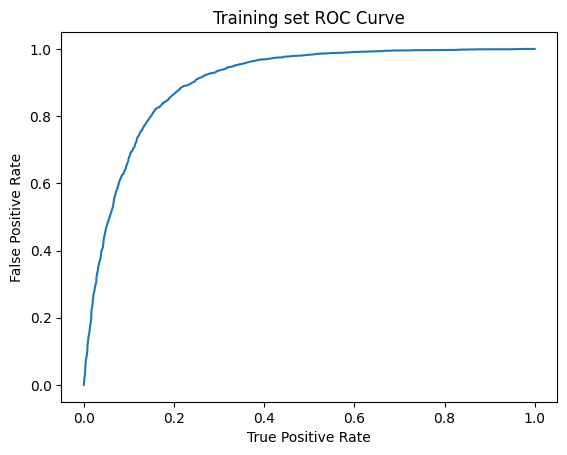

In [ ]:
# Plot ROC curve
train_summary  = model.summary
roc = train_summary.roc.toPandas()
plt.plot(roc['FPR'], roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('Training set ROC Curve')
plt.show()

Now we will evaluate the performance of the model on the training data using two performance metrics namely accuracy and area under ROC curve.

In [ ]:
# Evaluation on training set
train_accuracy = train_summary.accuracy
train_areaUnderROC = train_summary.areaUnderROC
print("Training Accuracy :  ", train_accuracy)
print("Training Area Under ROC :  ",train_areaUnderROC)

Training Accuracy :   0.8264416629414394
Training Area Under ROC :   0.9027514887862209


In [ ]:
# Make prediction on test set
predictions = model.transform(test)
predictions.select('label','prediction').show(10)

+-----+----------+
|label|prediction|
+-----+----------+
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       1.0|
|  0.0|       0.0|
|  0.0|       0.0|
+-----+----------+
only showing top 10 rows



In [ ]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# Evaluation of model on test set
evaluator = BinaryClassificationEvaluator()
test_areaUnderROC = evaluator.evaluate(predictions)
test_accuracy = model.evaluate(test).accuracy
print('Test accuracy : ',test_accuracy)
print('Test Area Under ROC : ', test_areaUnderROC)

Test accuracy :  0.8292682926829268
Test Area Under ROC :  0.907886703615904


**The accuracy of the model when tested on previously unseen data turns out to be around 82.4% and the area under ROC curve is 0.9047. We see that there is not much difference between the performance of the model on training and testing data.**

**Hyper-parameter tuning**

While building the logistic regression model, we assigned the default hyperparameters for the model. Tuning these to find the optimal hyperparameters can greatly improve the model performance. To do that, we can perform grid search using ParamGridBuilder and CrossValidator which is equivalent to Sklearn's GridSearchCV.

In [ ]:
# Hyperparameter tuning

from  pyspark.ml.tuning import ParamGridBuilder, CrossValidator

# Create ParamGrid for Cross Validation
paramGrid = (ParamGridBuilder()
             .addGrid(log_reg.regParam, [0.01, 0.5, 0.1])
             .addGrid(log_reg.elasticNetParam, [0.0, 0.5, 1.0])
             .addGrid(log_reg.maxIter, [2, 5, 10])
             .build())

cv = CrossValidator(estimator = log_reg, estimatorParamMaps = paramGrid,
                  evaluator = evaluator, numFolds=5)

cv_model = cv.fit(train)
predictions = cv_model.bestModel.transform(test)
print('Test Area Under ROC after parameter tuning ',evaluator.evaluate(predictions))

Test Area Under ROC after parameter tuning  0.908710049836276


This is the area under ROC curve of the best possible classification model created from various combinations of the specified hyperparameter values.